# Generate Twitter Dataset

## The Original Dataset Structure

Date is ranging from 2020-01-27 to 2021-09-01, and not all cloumns are needed.

In [76]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

appName = "Generate Twitter Dataset"
spark = SparkSession.builder.appName(appName).getOrCreate()

shrink the dataset

the original dataset takes 5GB and has over 54,000,000 lines, so I shrink it by sampling.

In [77]:
shrink_factor = 10

twitter_raw = open("../datasets/twitter_raw.csv", "r")
twitter_shrinked = open("../datasets/twitter_shrinked.csv", "w")

count = 0
for line in twitter_raw:
    if count % shrink_factor == 0:
        twitter_shrinked.write(line)
    count += 1

twitter_raw.close()
twitter_shrinked.close()

In [78]:
data = spark.read.csv("../datasets/twitter_shrinked.csv", header=True, inferSchema=True)

data = data.select(
    col("tweet_timestamp").cast("string").alias("time"),
    col("happiness_intensity").cast("float").alias("happiness"),
    col("valence_intensity").cast("float").alias("valence"),
    col("fear_intensity").cast("float").alias("fear"),
    col("anger_intensity").cast("float").alias("anger"),
    col("sadness_intensity").cast("float").alias("sadness")
)

In [79]:
data = data.withColumn("time", substring("time", 1, 10))

data = data.groupBy("time").agg({
    "happiness": "avg",
    "valence": "avg",
    "fear": "avg",
    "anger": "avg",
    "sadness": "avg"
})

data = data.withColumn("time", to_date(col("time"), "yyyy-MM-dd"))

data = data.sort("time")

In [80]:
data = data.select(
    col("time"),
    col("avg(happiness)").alias("happiness"),
    col("avg(valence)").alias("valence"),
    col("avg(fear)").alias("fear"),
    col("avg(anger)").alias("anger"),
    col("avg(sadness)").alias("sadness")
)

In [114]:
import numpy as np

time = data.select("time").collect()
happiness = np.float64(data.select("happiness").collect())[:, 0]
valence = np.float64(data.select("valence").collect())[:, 0]
fear = np.float64(data.select("fear").collect())[:, 0]
anger = np.float64(data.select("anger").collect())[:, 0]
sadness = np.float64(data.select("sadness").collect())[:, 0]

features = [happiness, valence, fear, anger, sadness]

C:\Users\regis\AppData\Local\Temp\ipykernel_24932\191647680.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(time, happiness, marker='', linestyle='-')
C:\Users\regis\AppData\Local\Temp\ipykernel_24932\191647680.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(time, valence, marker='', linestyle='-')
C:\Users\regis\AppData\Local\Temp\ipykernel_24932\191647680.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(time, fear, marker='', linestyle='-')
C:\Users\regis\AppData\Local\Temp\ipykernel_24932\191647680.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt str

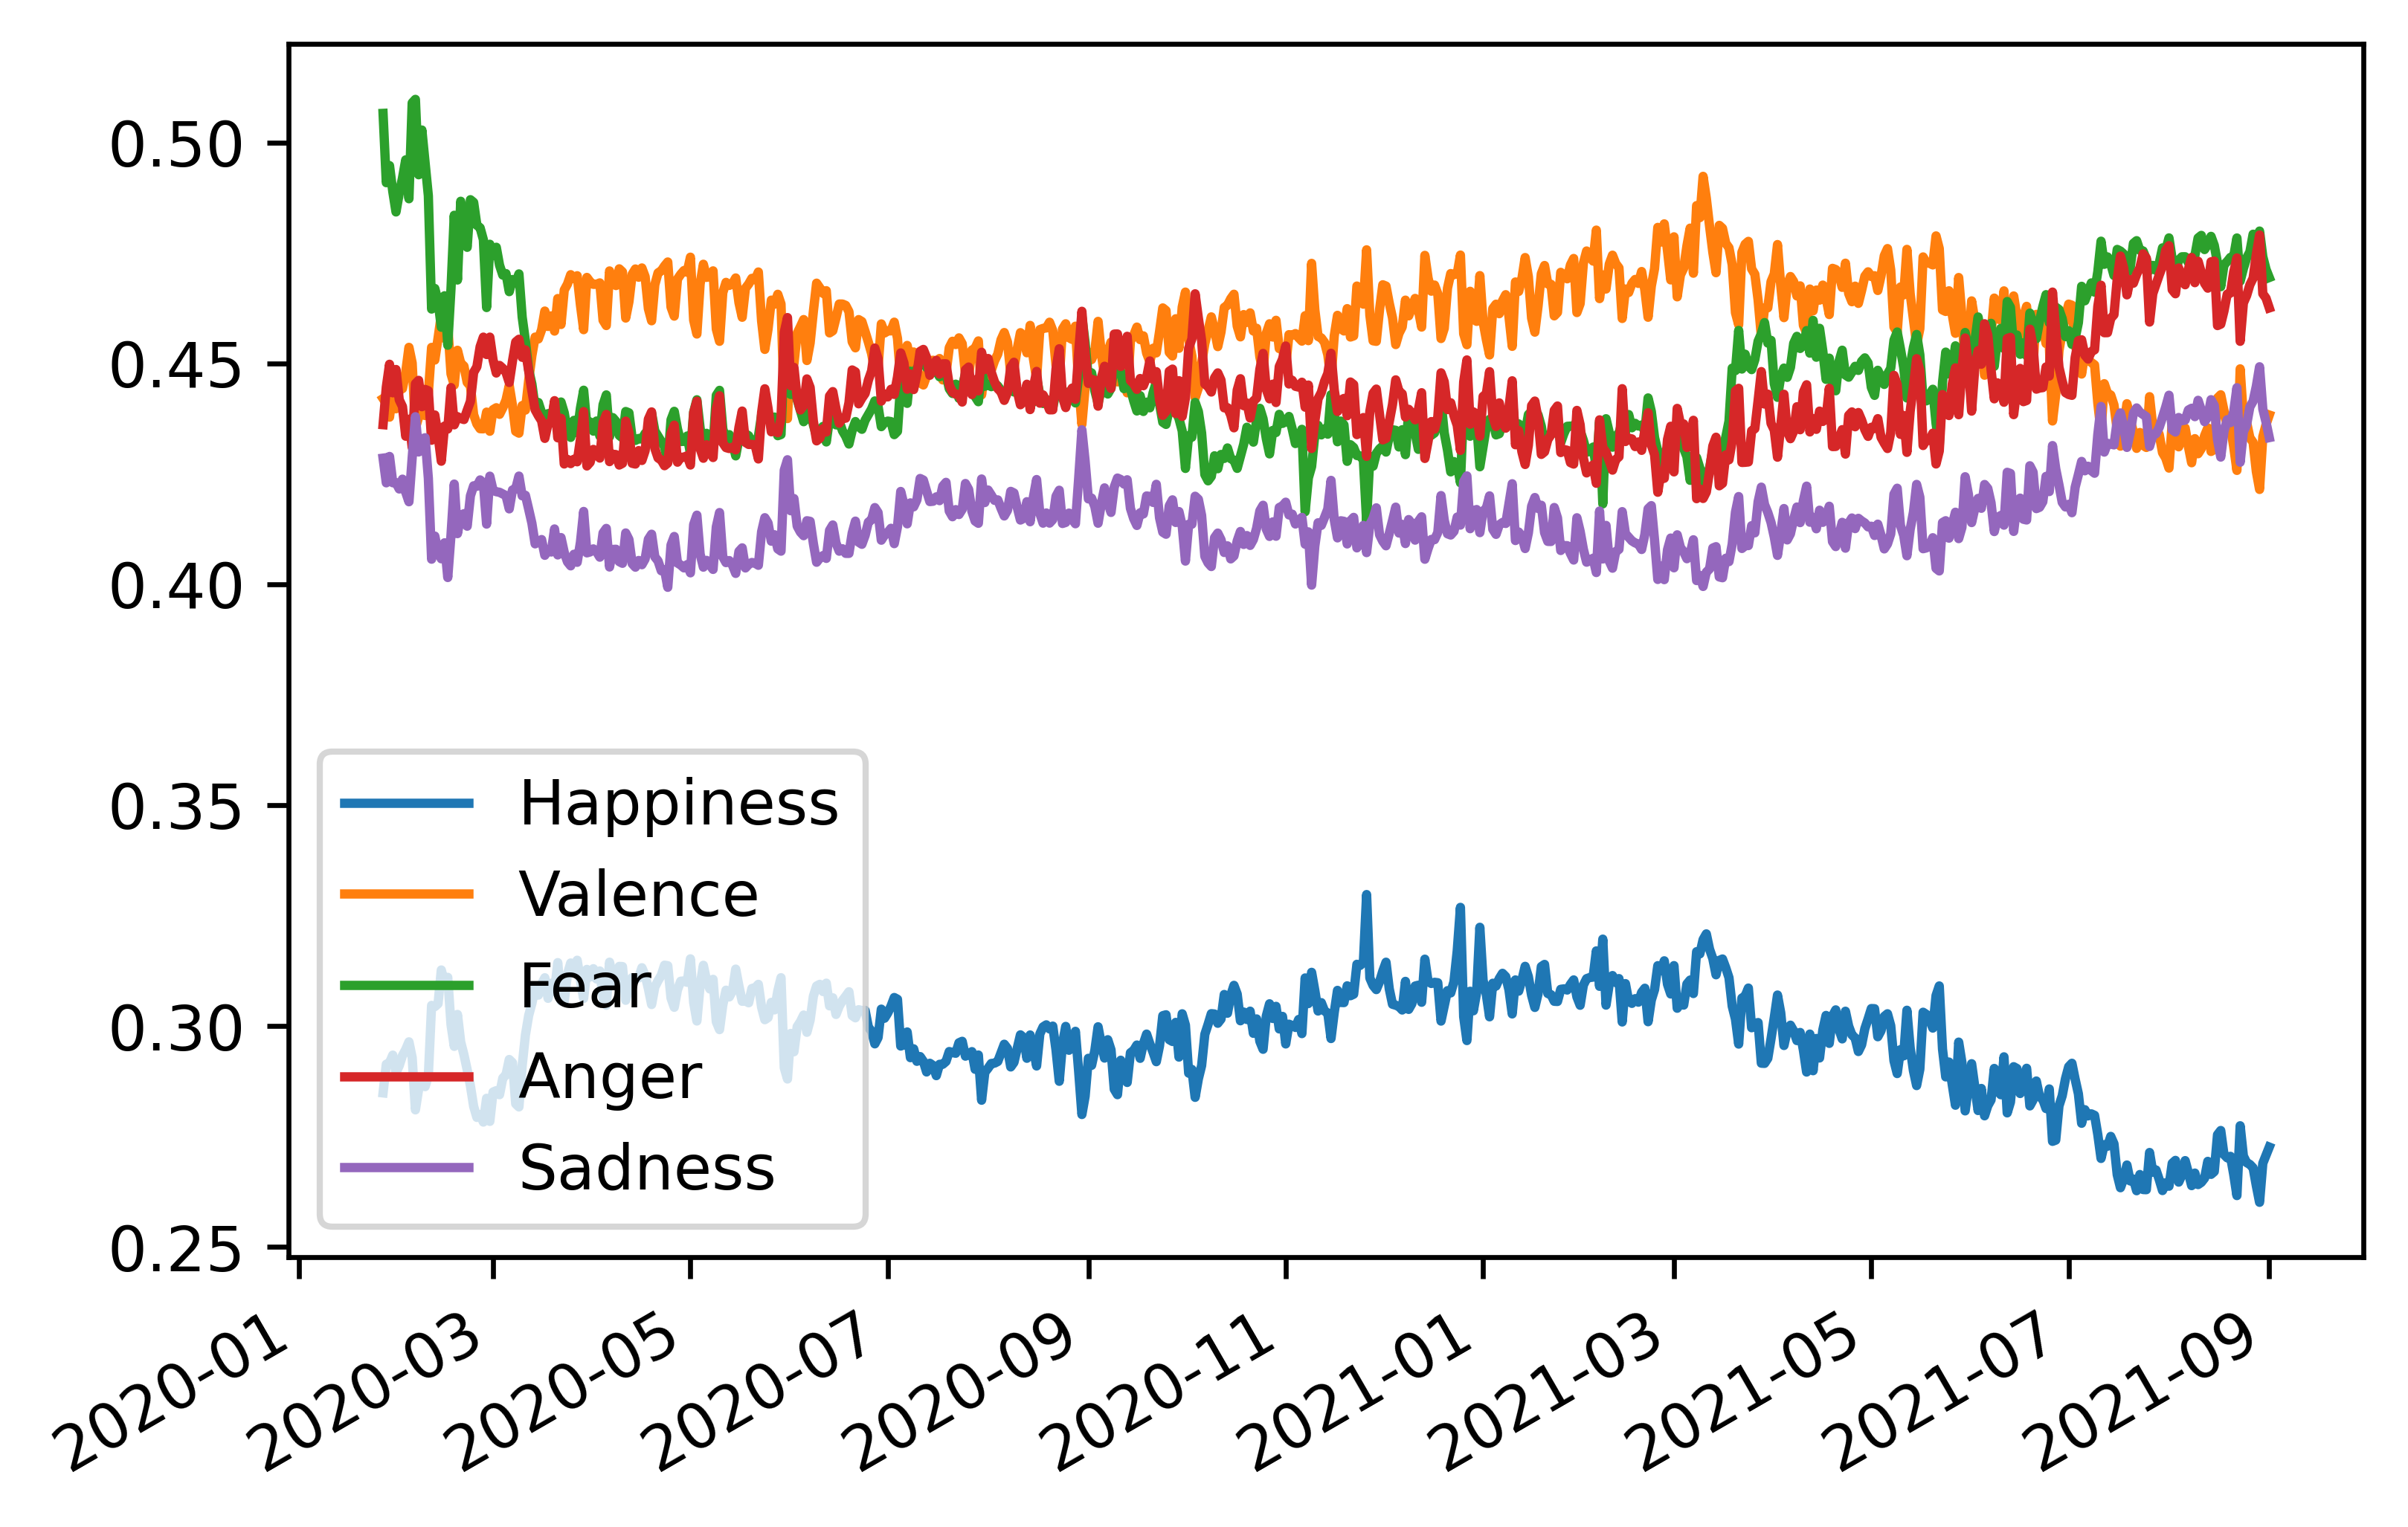

In [115]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 300

fig, ax = plt.subplots()
ax.plot_date(time, happiness, marker='', linestyle='-')
ax.plot_date(time, valence, marker='', linestyle='-')
ax.plot_date(time, fear, marker='', linestyle='-')
ax.plot_date(time, anger, marker='', linestyle='-')
ax.plot_date(time, sadness, marker='', linestyle='-')
ax.set_aspect('auto')
fig.autofmt_xdate()

plt.legend(['Happiness', 'Valence', 'Fear', 'Anger', 'Sadness'])

plt.show()

In [135]:
kernel = np.array([1,1,2,1,1])
kernel = kernel / np.sum(kernel)

bluredHappiness = np.convolve(happiness, kernel, mode="valid")
bluredValence = np.convolve(valence, kernel, mode="valid")
bluredFear = np.convolve(fear, kernel, mode="valid")
bluredAnger = np.convolve(anger, kernel, mode="valid")
bluredSadness = np.convolve(sadness, kernel, mode="valid")

C:\Users\regis\AppData\Local\Temp\ipykernel_24932\47690575.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(time[start:end], bluredHappiness, marker='', linestyle='-')
C:\Users\regis\AppData\Local\Temp\ipykernel_24932\47690575.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(time[start:end], bluredValence, marker='', linestyle='-')
C:\Users\regis\AppData\Local\Temp\ipykernel_24932\47690575.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(time[start:end], bluredFear, marker='', linestyle='-')
C:\Users\regis\AppData\Local\Temp\ipykernel_24932\47690575.py:11: UserWarning: marker is redundantly defined 

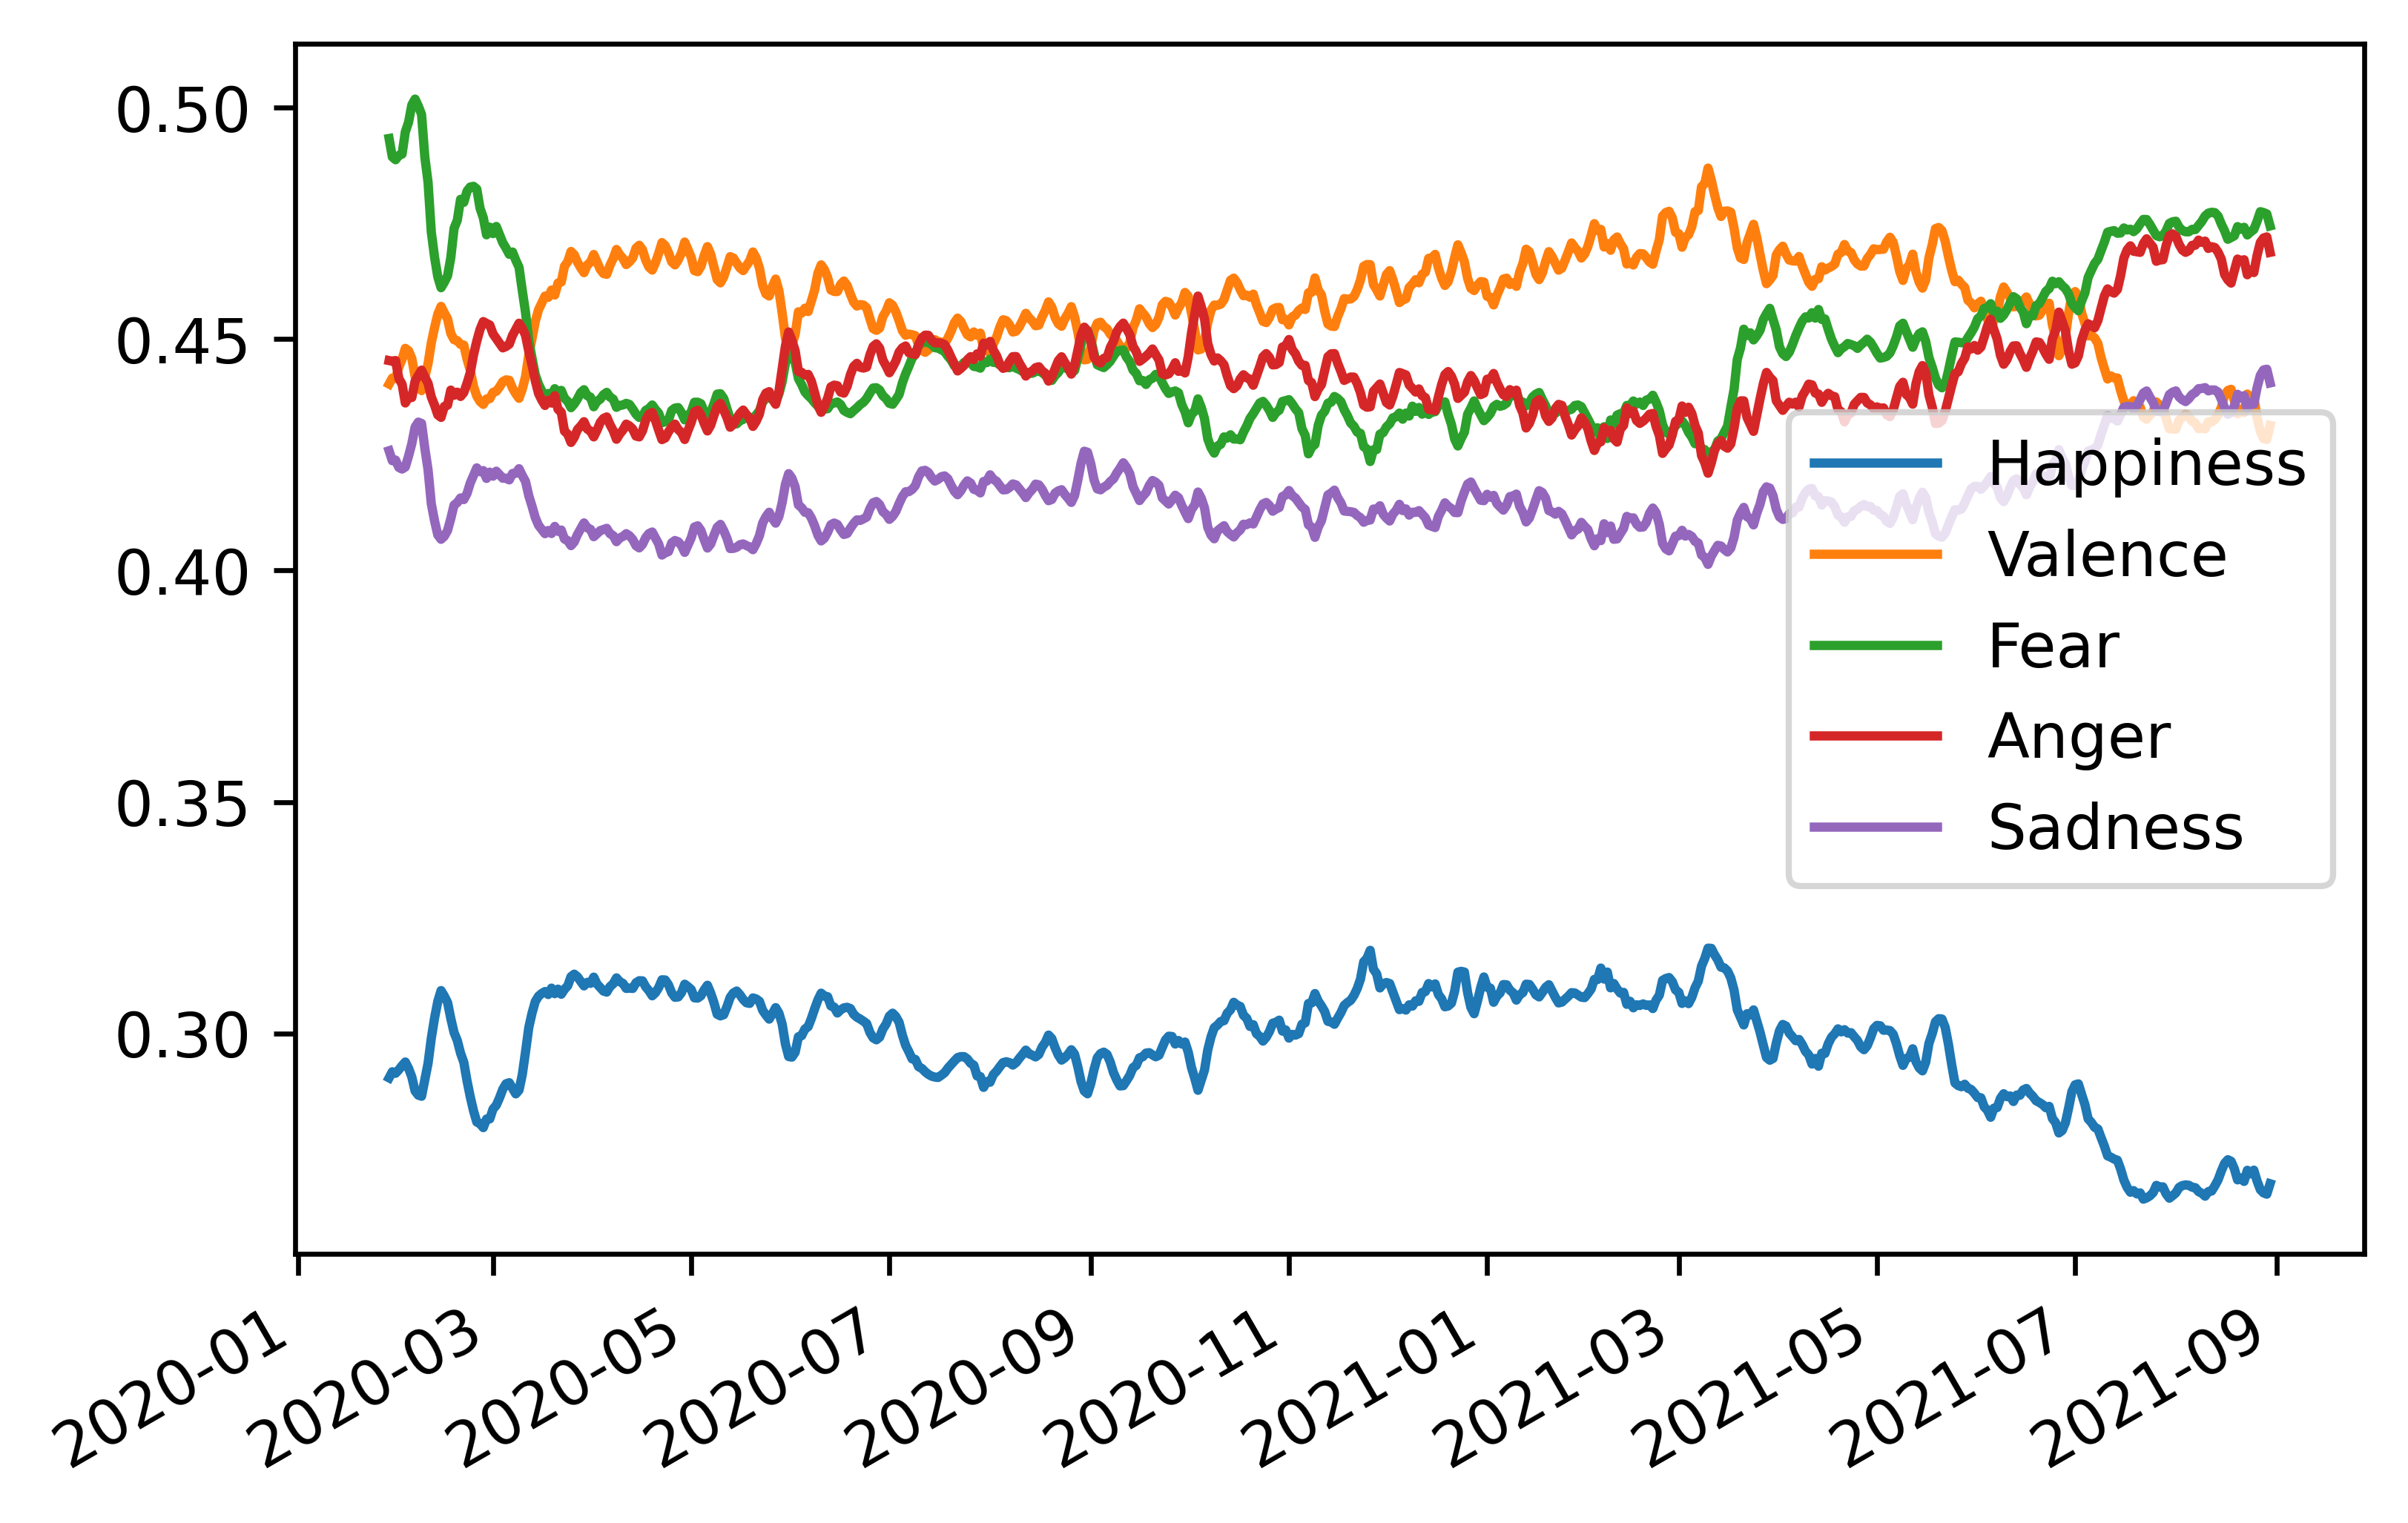

In [136]:
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 300

start = len(kernel) // 2
end = - len(kernel) + len(kernel) // 2 + 1

fig, ax = plt.subplots()
ax.plot_date(time[start:end], bluredHappiness, marker='', linestyle='-')
ax.plot_date(time[start:end], bluredValence, marker='', linestyle='-')
ax.plot_date(time[start:end], bluredFear, marker='', linestyle='-')
ax.plot_date(time[start:end], bluredAnger, marker='', linestyle='-')
ax.plot_date(time[start:end], bluredSadness, marker='', linestyle='-')
ax.set_aspect('auto')
fig.autofmt_xdate()

plt.legend(['Happiness', 'Valence', 'Fear', 'Anger', 'Sadness'])

plt.show()

In [140]:
from pandas import DataFrame

dataList = DataFrame({
    "date": time[start:end],
    'happiness': bluredHappiness,
    'sadness': bluredSadness,
    'fear': bluredFear,
    'anger': bluredAnger,
    'valence': bluredValence,
})

In [142]:
# data.write.csv("../datasets/twitter_dataset.csv", header=True)
dataList.to_csv("../datasets/twitter_dataset.csv", header=True)